# Constrained transcripts
This script summarises transcript level constraints against nonsense variants in the UKB exomes.

We produce a list of genes where:
- The whole transcript is constrained for nonsense variants
- The transcript is constrained in our dataset, but does not meet the pLI / LOEUF thresholds
- The transcript is constrained specifically in NMD-escaping regions, stratified by:
  - 3' regions, long-exons
  - Unconstrained target regions, low pLI, high LOEUF
  
We produce two text files as output:
- Transcript level nonsense constraint
- asd 

## Preliminaries
Import modules, set plotting aesthetics, and download necessary data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

sns.set_context("talk")

In [3]:
%%bash

dx download -f data/supplementary_dataset_11_full_constraint_metrics.tsv -o ../data/

## Nonsense constraint across whole transcripts
Assess constraint against nonsense variants in the full length of the transcript

In [4]:
# Read the constraint data to memory
df = pd.read_csv("../outputs/expected_variants_stats_no_cpg.tsv", sep="\t")

# Reformat the dataframe
df = df[["enst","csq","n_pos","prop_exp","n_exp","prop_obs","n_obs","oe","oe_diff","z","p"]]
df = df.set_index(["enst","csq"]).unstack("csq")
df.columns = df.columns.swaplevel(0,1)
df.sort_index(axis=1, level=0, inplace=True, sort_remaining=False)
df.columns = df.columns.set_levels(["mis","non","syn"], level=0)
df.columns = ["_".join(x) for x in df.columns.to_flat_index()]

df.shape

(19623, 27)

In [5]:
# Exclude transcripts with fewer synonymous variants than expected
# These likely represent poorly covered transcripts

m1 = df["syn_n_obs"] > 10
m2 = df["syn_z"] >= -1
m3 = df["mis_n_obs"] > 10

df = df[m1 & m2 & m3]
df.shape

(14473, 27)

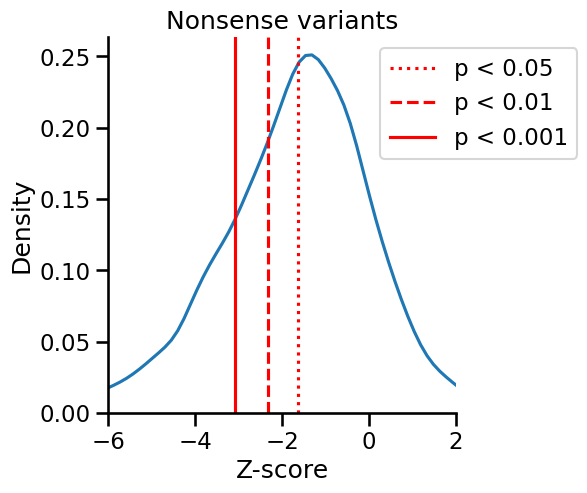

In [6]:
# Plot the distribution of nonsense Z-scores
g = sns.displot(kind="kde",
                data=df,
                x=("non_z")
               )
g.set(xlim=(-6,2),
      title="Nonsense variants",
      xlabel="Z-score",
     )

# Add vertical lines for significance thresholds
p_values = 0.05, 0.01, 0.001
linestyles = ":", "--", "-"

for p, l in zip(p_values, linestyles):
    plt.axvline(x = norm.ppf(p), # Critical value for one-tail Z-test
                color="r", 
                linestyle=l,
                label = f"p < {p}"
               )

# Adjust the legend position
plt.legend(bbox_to_anchor = (0.75, 1), loc = 'upper left')

In [7]:
# Summarise the number of transcripts meeting p-value thresholds
def get_p_stats_transcript(df):
    p_vals = df[[("non_n_obs"), ("non_p")]].copy()
    p_vals["p_value_bin"] = pd.cut(p_vals["non_p"], bins=[0,0.001,0.01,0.05,1])
    p_stats = p_vals.groupby("p_value_bin").agg({"non_p":"count"})
    p_stats["zero_nonsense_observed"] = p_vals.groupby("p_value_bin")["non_n_obs"].apply(lambda x: (x==0).sum())
    p_stats.columns = ["transcripts","zero_nonsense_observed"]
    return p_stats

get_p_stats_transcript(df)

,transcripts,zero_nonsense_observed
p_value_bin,,
"(0.0, 0.001]",2998,249
"(0.001, 0.01]",1789,126
"(0.01, 0.05]",2165,141
"(0.05, 1.0]",7521,50


## Compare Z-scores against LOEUF

In [8]:
# Get gnomAD pLI and LOEUF constraint data
pli = pd.read_csv("../data/supplementary_dataset_11_full_constraint_metrics.tsv", sep="\t")
pli = pli.rename(columns={"transcript":"enst", "pLI":"pli"})
pli = pli.set_index("enst")

In [9]:
# Merge UKB and gnomAD constraint data
df = df.join(pli[["pli", "oe_lof_upper"]], how="left")

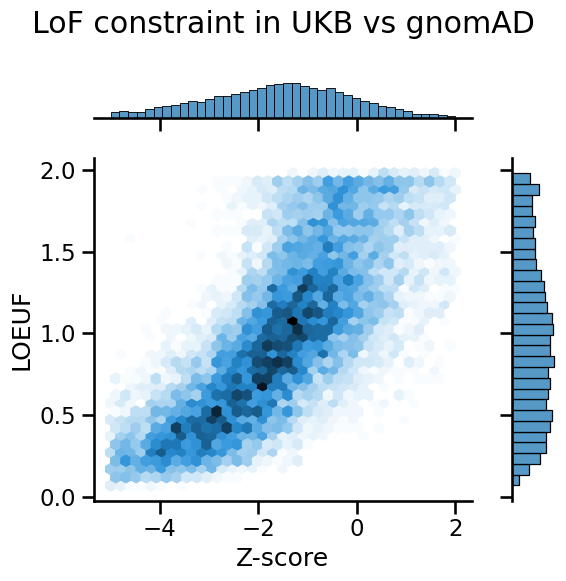

In [10]:
# Plot the relationship between the UKB nonsense Z-score and the gnomAD LOEUF score
g = sns.jointplot(data=df[df["non_z"].between(-5,2)],
            x=("non_z"),
            y="oe_lof_upper",
            kind="hex",
                 )
g.set_axis_labels(xlabel="Z-score",
                  ylabel="LOEUF",
                 )
g.fig.suptitle("LoF constraint in UKB vs gnomAD")
g.fig.tight_layout()

## Find new transcripts constrained for nonsense variants
The greater sample size of UKB may allow us to detect nonsense constraint in more transcripts than in gnomAD. This is particularly true for small transcripts.

### pLI

In [11]:
get_p_stats_transcript(df[(df["pli"] < 0.9) | (df["pli"].isna())])

,transcripts,zero_nonsense_observed
p_value_bin,,
"(0.0, 0.001]",1513,59
"(0.001, 0.01]",1459,72
"(0.01, 0.05]",2042,127
"(0.05, 1.0]",7480,50


### LOEUF

In [12]:
get_p_stats_transcript(df[(df["oe_lof_upper"] > 0.35) | (df["oe_lof_upper"].isna())])

,transcripts,zero_nonsense_observed
p_value_bin,,
"(0.0, 0.001]",1481,73
"(0.001, 0.01]",1506,83
"(0.01, 0.05]",2080,135
"(0.05, 1.0]",7495,50


## Save constrained transcripts to output

In [17]:
m1 = df["non_p"] < 0.001
m2 = df["non_p"] < 0.01
m3 = df["non_n_obs"] == 0

(df[m1 | (m2 & m3)]
    .sort_values(["non_n_obs", "non_p"])
    .to_csv("../outputs/constrained_transcripts.tsv", index=True, sep="\t")
)

## Regional NMD constraint
Find constraint against nonsense variants in NMD-escaping and NMD-triggering regions

In [30]:
# Read NMD constraint data to memory
nmd = pd.read_csv("../outputs/expected_variants_stats_no_cpg_nmd.tsv", sep="\t")

# Reformat data
nmd = nmd.set_index(["enst","csq","nmd"]).unstack(["csq", "nmd"])
nmd.columns = nmd.columns.swaplevel(0,2).swaplevel(0,1)
nmd.sort_index(axis=1, level=[0,1], inplace=True, sort_remaining=False)
nmd.columns = nmd.columns.set_levels(["mis","non","syn"], level=0)
nmd.columns = nmd.columns.set_levels(["distal","long_exon","nmd","proximal"], level=1)
nmd.columns = ["_".join(x) for x in nmd.columns.to_flat_index()]

# Merge with pLI and LOEUF annotations
pli = pli[["pli", "oe_lof_upper"]]
nmd = nmd.join(pli, how="left")

### Plot regional nonsense constraint Z-scores

In [38]:
def plot_regional_z_score(df, x, title):
    g = sns.displot(kind="kde",
                    data=df,
                    x = x
                   )
    g.set(title=title,
          xlabel="Z-score",
          xlim=(-5,5))

    plt.axvline(x=-1.645, color="r", linestyle=":", label = "p < 0.05")
    plt.axvline(x=-2.326, color="r", linestyle="--", label = "p < 0.01")
    plt.axvline(x=-3.09, color="r", linestyle="-", label = "p < 0.001")

    plt.legend(bbox_to_anchor = (0.5, 0.9), loc = 'upper left')
    
    return g

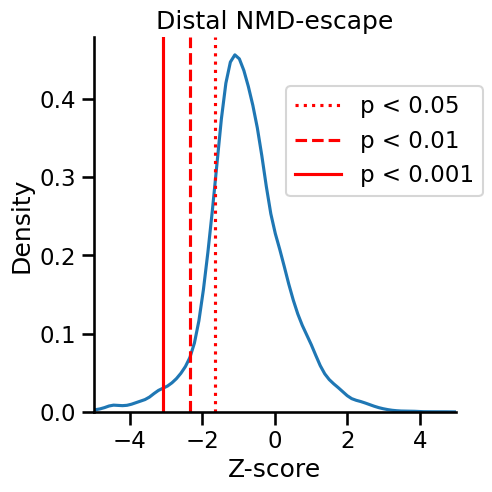

In [39]:
g = plot_regional_z_score(df=nmd, x="non_distal_z", title="Distal NMD-escape")

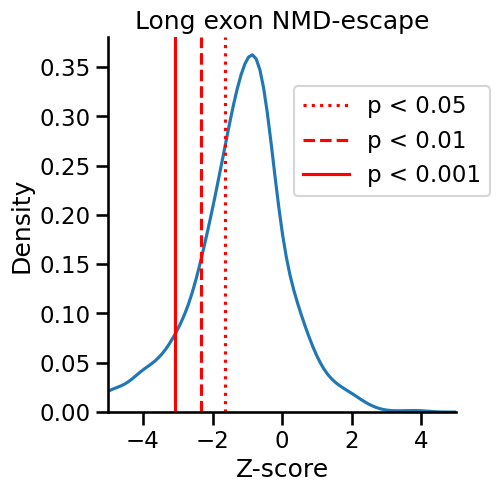

In [40]:
g = plot_regional_z_score(df=nmd, x="non_long_exon_z", title="Long exon NMD-escape")

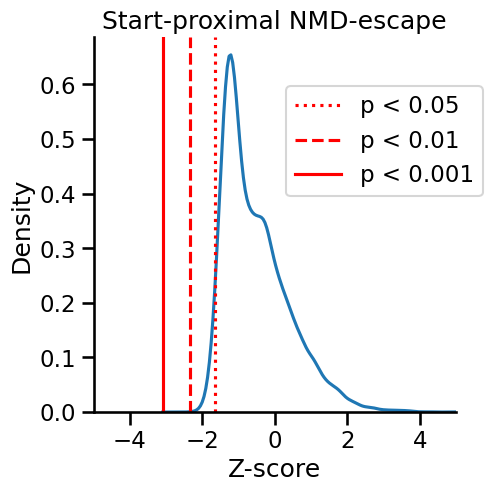

In [41]:
g = plot_regional_z_score(df=nmd, x="non_proximal_z", title="Start-proximal NMD-escape")

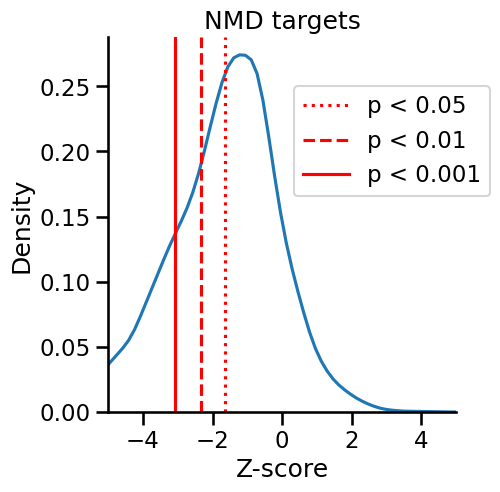

In [42]:
g = plot_regional_z_score(df=nmd, x="non_nmd_z", title="NMD targets")

### Distal NMD-escape

In [15]:
df = nmd.copy()

for region in ["distal","long_exon","nmd","proximal"]:
    m1 = df["non_" + region + "_p"] < 0.001
    m2 = df["non_" + region + "_p"] < 0.01
    m3 = df["non_" + region + "_n_obs"] == 0
    m4 = df["syn_" + region + "_z"] > -1

    df[region] = np.where(m4 & (m1 | (m2 & m3)), region + ",", "")
    
df["constrained_region"] = ["".join([w,x,y,z]) for w,x,y,z in zip(df["distal"],df["long_exon"],df["nmd"], df["proximal"])]

# Summarise the number of transcripts meeting p-value thresholds
def get_p_stats(df, region):
    p_vals = df[[("nonsense", region,"n_obs"), ("nonsense", region,"p")]].copy()
    p_vals.columns = ["n_obs","p"]
    p_vals["p_bin"] = pd.cut(p_vals["p"], bins=[0,0.001,0.01,0.05,1])
    p_stats = p_vals.groupby("p_bin").agg({"p":"count"})
    p_stats["none_observed"] = p_vals.groupby("p_bin")["n_obs"].apply(lambda x: (x==0).sum())
    return p_stats

p_stats = get_p_stats(df, region)
p_stats

Remaining transcripts: 15096


,p,none_observed
p_bin,,
"(0.0, 0.001]",290,59
"(0.001, 0.01]",414,82
"(0.01, 0.05]",1439,750
"(0.05, 1.0]",12837,3489


### Long exon NMD-escape

In [16]:
region = "long_exon"
df = nmd.copy()

# Exclude transcripts with low synonymous Z-scores
df = df[df[("synonymous", region, "z")] > -1]
print(f"Remaining transcripts: {len(df)}")

# Summarise the number of transcripts meeting p-value thresholds
p_stats = get_p_stats(df, region)
p_stats

Remaining transcripts: 2903


,p,none_observed
p_bin,,
"(0.0, 0.001]",266,56
"(0.001, 0.01]",221,71
"(0.01, 0.05]",397,156
"(0.05, 1.0]",1949,644


### NMD-targeted regions

In [17]:
region = "nmd_target"
df = nmd.copy()

# Exclude transcripts with low synonymous Z-scores
df = df[df[("synonymous", region, "z")] > -1]
print(f"Remaining transcripts: {len(df)}")

# Summarise the number of transcripts meeting p-value thresholds
p_stats = get_p_stats(df, region)
p_stats

Remaining transcripts: 12087


,p,none_observed
p_bin,,
"(0.0, 0.001]",1976,275
"(0.001, 0.01]",1309,196
"(0.01, 0.05]",1813,314
"(0.05, 1.0]",6926,962


## NMD region-specific constraint

### NMD region-specific constraint in transcripts unconstrained in NMD-target regions

In [69]:
def region_constraint(df, region):
    m1 = df["synonymous",region,"z"]>-1
    m2 = df["nonsense",region,"p"]<0.001
    m3 = df["nonsense",region,"p"]<0.01
    m4 = df["nonsense",region,"n_obs"]==0
    m5 = df["nonsense","nmd_target", "p"] > 0.05
    m6 = df["nonsense","nmd_target", "p"].isna()

    df = df[(m1 & (m2 | (m3 & m4))) & (m5 | m6)]
    df = df.loc[:,(["nonsense"], [region, "nmd_target"], ["n_pos","n_exp","n_obs","oe","z","p","pli","loeuf"])]
    df = df.sort_values(("nonsense", "nmd_target", "n_exp"), ascending=False)

    return df

distal = region_constraint(nmd, "distal_nmd")
long_exon = region_constraint(nmd, "long_exon")
start_proximal = region_constraint(nmd, "start_proximal")

print(len(distal), len(long_exon), len(start_proximal))

215 25 0


### NMD region-specific constraint in low pLI transcripts

In [72]:
def region_constraint_pli(df, region):
    m1 = df["synonymous",region,"z"]>-1
    m2 = df["nonsense",region,"p"]<0.001
    m3 = df["nonsense",region,"p"]<0.01
    m4 = df["nonsense",region,"n_obs"]==0
    m5 = df["nonsense","nmd_target", "pli"] < 0.9
    m6 = df["nonsense","nmd_target", "pli"].isna()

    df = df[(m1 & (m2 | (m3 & m4))) & (m5 | m6)]
    df = df.loc[:,(["nonsense"], [region, "nmd_target"], ["n_pos","n_exp","n_obs","oe","z","p","pli","loeuf"])]
    df = df.sort_values(("nonsense", "nmd_target", "n_exp"), ascending=False)

    return df

distal = region_constraint_pli(nmd, "distal_nmd")
long_exon = region_constraint_pli(nmd, "long_exon")
start_proximal = region_constraint_pli(nmd, "start_proximal")

print(len(distal), len(long_exon), len(start_proximal))

187 128 0


### NMD region-specific constraint in high LOEUF transcripts

In [71]:
def region_constraint_loeuf(df, region):
    m1 = df["synonymous",region,"z"]>-1
    m2 = df["nonsense",region,"p"]<0.001
    m3 = df["nonsense",region,"p"]<0.01
    m4 = df["nonsense",region,"n_obs"]==0
    m5 = df["nonsense","nmd_target", "loeuf"] > 0.35
    m6 = df["nonsense","nmd_target", "loeuf"].isna()

    df = df[(m1 & (m2 | (m3 & m4))) & (m5 | m6)]
    df = df.loc[:,(["nonsense"], [region, "nmd_target"], ["n_pos","n_exp","n_obs","oe","z","p","pli","loeuf"])]
    df = df.sort_values(("nonsense", "nmd_target", "n_exp"), ascending=False)

    return df

distal = region_constraint_loeuf(nmd, "distal_nmd")
long_exon = region_constraint_loeuf(nmd, "long_exon")
start_proximal = region_constraint_loeuf(nmd, "start_proximal")

print(len(distal), len(long_exon), len(start_proximal))

195 125 0
